PACKAGES

In [2]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c211c979001e4aa4f2be17377e235e07efdbfcf9008ab7946811207c8a1bacc1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
import json
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
#import tensorflow_addons as tfa
import sklearn as sk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing data

In [6]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]
path_to_training = Path("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/training")
path_to_test = Path("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/test")

In [7]:
#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])
#####
# text_baseline: utterances are embedded with SentenceTransformer, then train a DL classifier.
#####
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')

y_training = []
with open("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = []
#index_training = []
relation_list = []
for transcription_id in training_set:
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)

    with open(path_to_training / f"{transcription_id}.txt", "r") as file:
        transcription_relationship = file.readlines()
    count = 0
    for utterance in transcription:
      if count == len(transcription)-1:
        relation = "end of transcription"
      else:
        relation = transcription_relationship[count].split()[1]
      tmp = utterance["speaker"].lower() + ": " + utterance["text"].lower()
      X_training.append(tmp)
      relation_list.append(relation.lower())
      #index_training.append(utterance["index"])
      count+=1
    y_training += training_labels[transcription_id]


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [8]:
relation_list[395]

'end of transcription'

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Example data
relation_one_hot = np.array(relation_list).reshape(-1, 1)

# Create the encoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
relation_one_hot = encoder.fit_transform(relation_one_hot)

relation_one_hot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(72623, 17)

In [ ]:
X_training

## Data Cleaning

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from wordcloud import WordCloud

In [ ]:
X_true = [X_training[i] for i in range(len(X_training)) if y_training[i] == 1]
X_false = [X_training[i] for i in range(len(X_training)) if y_training[i] == 0]
X_true

Visualising vocal sound

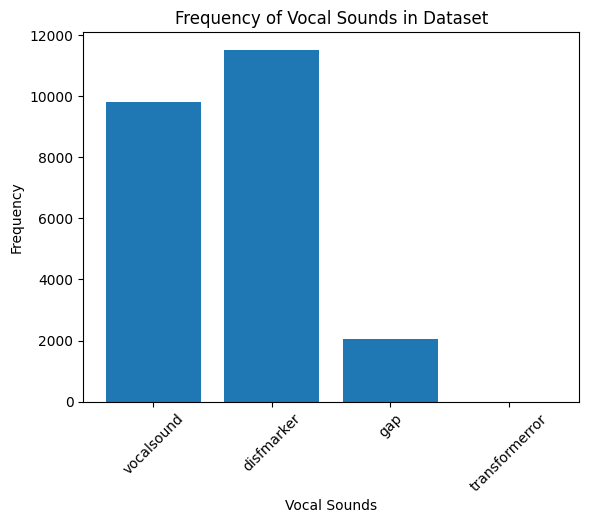

In [10]:

# Extract vocal sounds from each sentence
vocal_sounds = []
for sentence in X_training:
    found_sounds = re.findall(r"<(.*?)>", sentence)
    vocal_sounds.extend(found_sounds)

# Count the frequency of each vocal sound
sound_counts = Counter(vocal_sounds)

# Unpack the sounds and their counts
sounds, counts = zip(*sound_counts.items())

# Create a bar chart
plt.bar(sounds, counts)
plt.xlabel('Vocal Sounds')
plt.ylabel('Frequency')
plt.title('Frequency of Vocal Sounds in Dataset')
plt.xticks(rotation=45)
plt.show()


Word frequency distribution

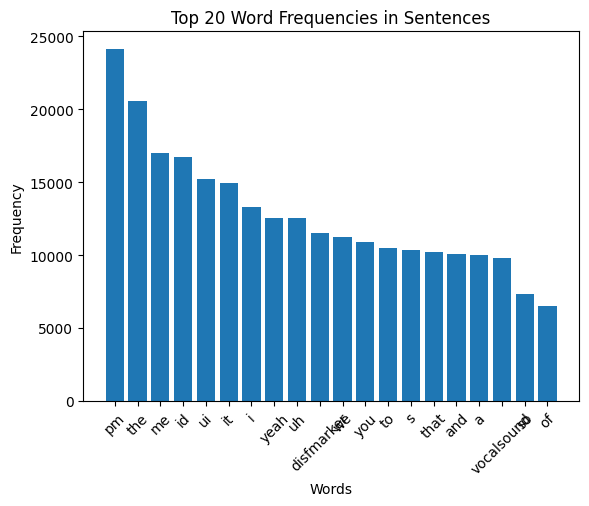

In [11]:

# Example array of sentences
sentences = ["This is a sentence.", "Another sentence with different words.", "Yet another sentence."]

# Split sentences into words and count frequency
word_counts = Counter(word for sentence in X_training for word in re.findall(r'\w+', sentence))

# Plotting
top = 20
words, counts = zip(*word_counts.most_common(20))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title(f'Top {top} Word Frequencies in Sentences')
plt.show()


Sentence length distribution

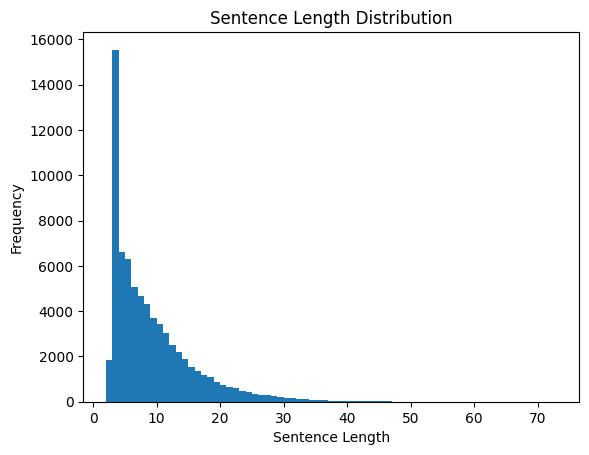

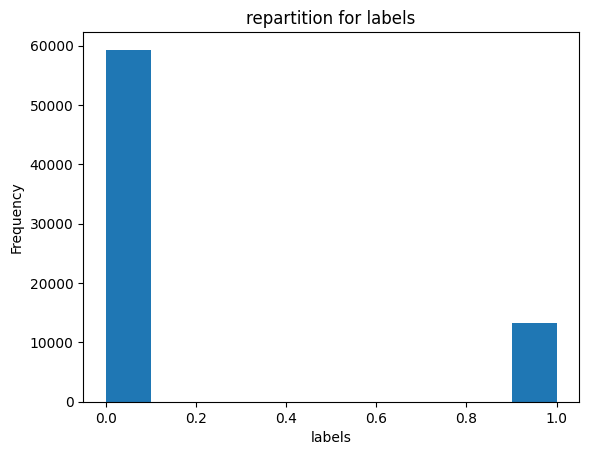

In [ ]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_training]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()
#plot label repartition
plt.hist(y_training)
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.title('repartition for labels')
plt.show()

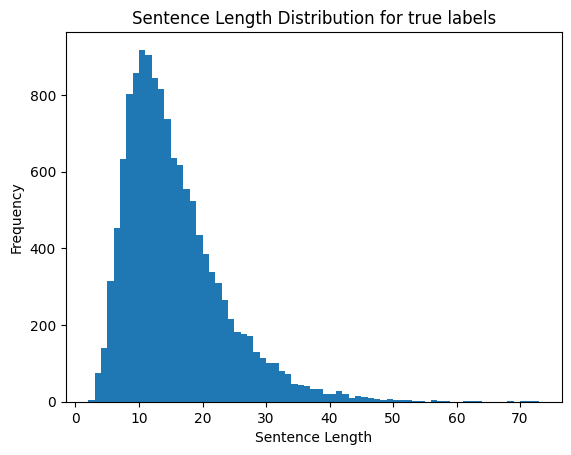

In [ ]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_true]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution for true labels')
plt.show()


In [ ]:
X_true[np.argmin(sentence_lengths)]

'ui: yeah'

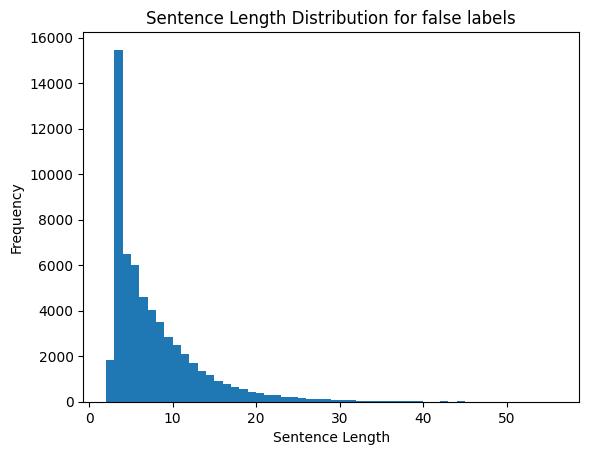

In [ ]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_false]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution for false labels')
plt.show()

Words cloud

Bigram frequency

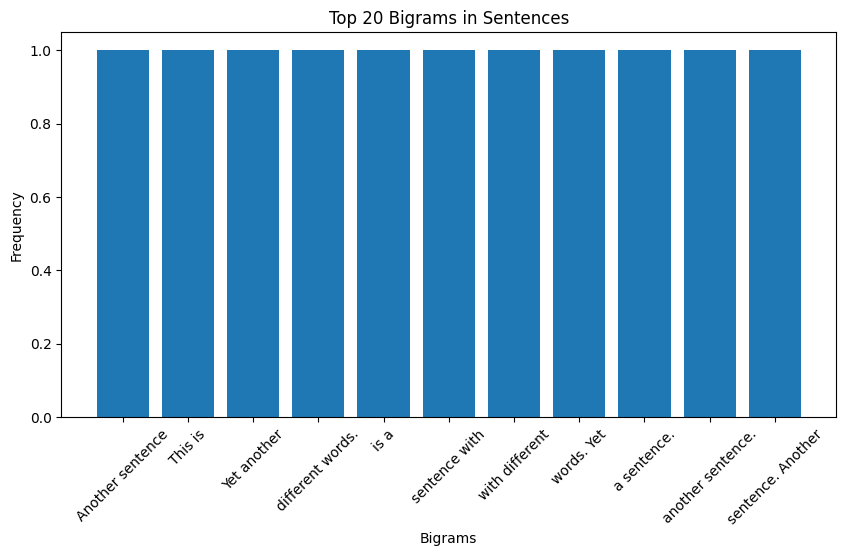

In [ ]:
from nltk import bigrams
from nltk.collocations import *

# Create bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word for sentence in sentences for word in sentence.split())

# Choose top 20 bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 20)

# Plotting
plt.figure(figsize=(10,5))
plt.bar(range(len(top_bigrams)), [finder.ngram_fd[bigram] for bigram in top_bigrams], tick_label=[f'{w1} {w2}' for w1, w2 in top_bigrams])
plt.xticks(rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Bigrams in Sentences')
plt.show()

Remove vocal sound

In [67]:
# Example array of sentences
# ANSI escape code for green text
GREEN = '\033[92m'  # This is for light green
RESET = '\033[0m'  # Reset to default color
RED = '\033[91m'  # This is for light red
RESET = '\033[0m'

# Function to remove vocal sounds from a sentence
def remove_vocal_sounds(sentence):   # Remove vocal sounds
    return re.sub(r"<[^>]*>", "", sentence)



# Remove vocal sounds from each sentence in the array
cleaned_sentences = [remove_vocal_sounds(sentence) for sentence in X_training]


In [ ]:
cleaned_sentences

Remove idiomatic sounds

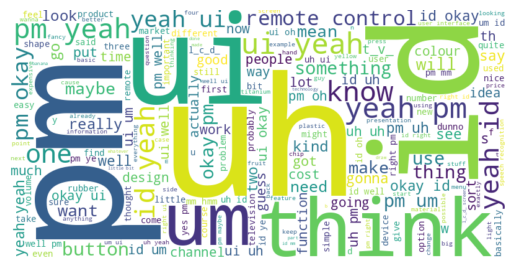

In [69]:
# Joining all sentences into a single text
all_text = ' '.join(cleaned_sentences)

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [70]:
idiomatic_sounds = ["um", "uh", "so", "actually", "literally","basically", "hmm", "oh", "really"]
def remove_idiomatic_sounds(sentence, sounds):
    for sound in sounds:
        sentence = sentence.replace(sound, "")
    return sentence
cleaned_sentences = [remove_idiomatic_sounds(sentence, idiomatic_sounds) for sentence in cleaned_sentences]

print(cleaned_sentences)

['pm: okay', 'pm: right', 'pm:   well this is the kick-off meeting for our our project .', 'pm:   and ', "pm: this is just what we're gonna be doing over the next twenty five minutes .", 'pm:   first of all , just to kind of make sure that we all know each other ,', "pm: i'm laura and i'm the project manager .", 'pm:  do you want to introduce yourself again ?', 'me: great .', "id: hi , i'm david and i'm supposed to be an industrial designer .", 'pm: okay .', "me: and i'm andrew and i'm  our marketing", "ui:  i'm craig and i'm user interface .", 'me: expert .', 'pm: great .', 'pm: okay .  ', "pm:  we're designing a new remote control and  ", "pm:  i have to record who's here  .", "pm:  that's david , andrew and craig , isn't it ?", 'pm: and you all arrived on time .', 'pm:  yeah  des   design a new remote control .', "pm:  , as you can see it's supposed to be original , trendy and user friendly .", "pm:   that's kind of our our brief , as it were .", 'pm:  and  there are three different

In [110]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize the text

# Remove the stop words
filtered_sentences = [word for word in cleaned_sentences if not word.lower() in stop_words]


#print(filtered_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
for i in range(50):
  if y_training[i] == 1:
    print(GREEN+cleaned_sentences[i]+RESET)
  else:
    print(RED+cleaned_sentences[i]+RESET)

In [ ]:
cleaned_sentences

## Relations visualisation

In [ ]:
#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])


X_relationships = []
for transcription_id in training_set:
    with open(path_to_training / f"{transcription_id}.txt", "r") as file:
        transcription = file.readlines()
        #print(transcription)
    X_relationships = X_relationships+transcription
#X_relationships = [line.strip() for line in transcription]
    #for utterance in transcription:
        #X_relationships.append(utterance["speaker"].lower() + ": " + utterance["text"].lower())

    #y_training += training_labels[transcription_id]
X_relationships = [line.strip() for line in X_relationships]

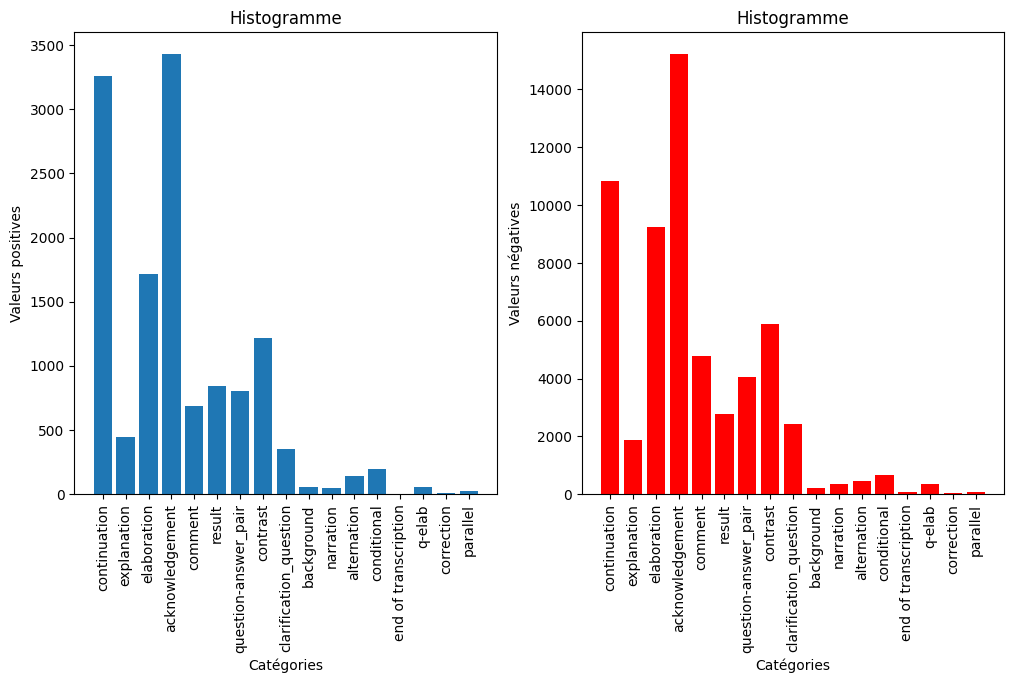

In [10]:
# Extraction des clés et des valeurs
count1 = {}
for i in range(len(relation_list)):
  count1[relation_list[i]] = count1.get(relation_list[i],0)+y_training[i]
categories1 = list(count1.keys())
values1 = list(count1.values())

# Création de l'histogramme
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.bar(categories1, values1)
# Ajout de titres et d'étiquettes
plt.xlabel("Catégories")
plt.ylabel("Valeurs positives")
plt.title("Histogramme")
plt.xticks(rotation=90)
# Afficher l'histogramme
count = {}
for i in range(len(y_training)):
  count[relation_list[i]] = count.get(relation_list[i],0)+(1-y_training[i])
categories = list(count.keys())
values = list(count.values())

plt.subplot(1,2,2)
plt.bar(categories, values, color = 'red')


# Ajout de titres et d'étiquettes
plt.xlabel("Catégories")
plt.ylabel("Valeurs négatives")
plt.title("Histogramme")
plt.xticks(rotation=90)
plt.show()

In [ ]:
X_relationships_list = [ sentence.split() for sentence in X_relationships]
len(X_relationships_list), len(y_training)

(72526, 72623)

In [ ]:
relationship = np.unique([sentence[1] for sentence in X_relationships_list])
relationship
count = {}

In [ ]:
for i in range(len(X_relationships_list)):
  count[X_relationships_list[i][1]] = count.get(X_relationships_list[i][1],0)+y_training[i]

### Histogram

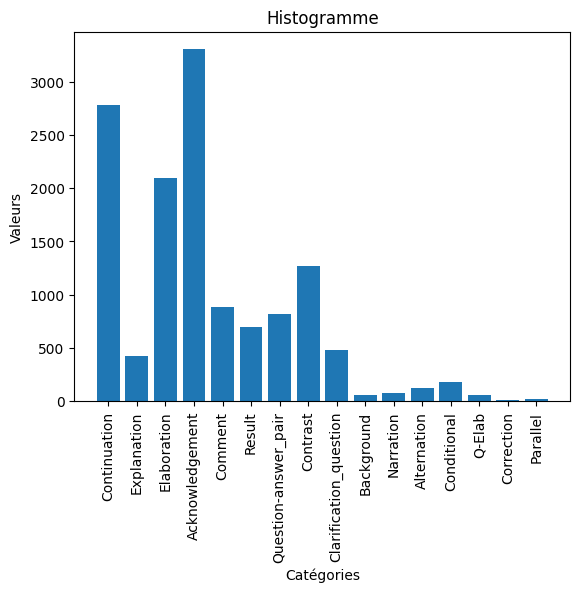

In [ ]:
# Extraction des clés et des valeurs
categories = list(count.keys())
values = list(count.values())

# Création de l'histogramme
#plt.figure(figsize=(12, 8))
plt.bar(categories, values)

# Ajout de titres et d'étiquettes
plt.xlabel("Catégories")
plt.ylabel("Valeurs")
plt.title("Histogramme")
plt.xticks(rotation='vertical')
# Afficher l'histogramme
plt.show()

In [ ]:
X_relationships_list[:5]

[['0', 'Question-answer_pair', '1'],
 ['1', 'Clarification_question', '2'],
 ['2', 'Continuation', '3'],
 ['2', 'Question-answer_pair', '4'],
 ['4', 'Elaboration', '5']]

In [ ]:
couple_link= {(int(sentence[0]), int(sentence[-1])): sentence[1] for sentence in X_relationships_list}

In [ ]:
couple_link

### Graph visualisation

In [ ]:
import networkx as nx
vertices = [key[0] for key in couple_link.keys()]+[key[1] for key in couple_link.keys()]
vertices= np.unique(vertices)
vertices

array([   0,    1,    2, ..., 1280, 1281, 1282])

In [ ]:
y_training

In [ ]:
node_colors = ["green" if y_training[i] == 1 else "red" for i in range(len(y_training))]
node_colors

In [ ]:
len(list(couple_link.keys())), len(y_training)

(1282, 72623)

### Graph showing

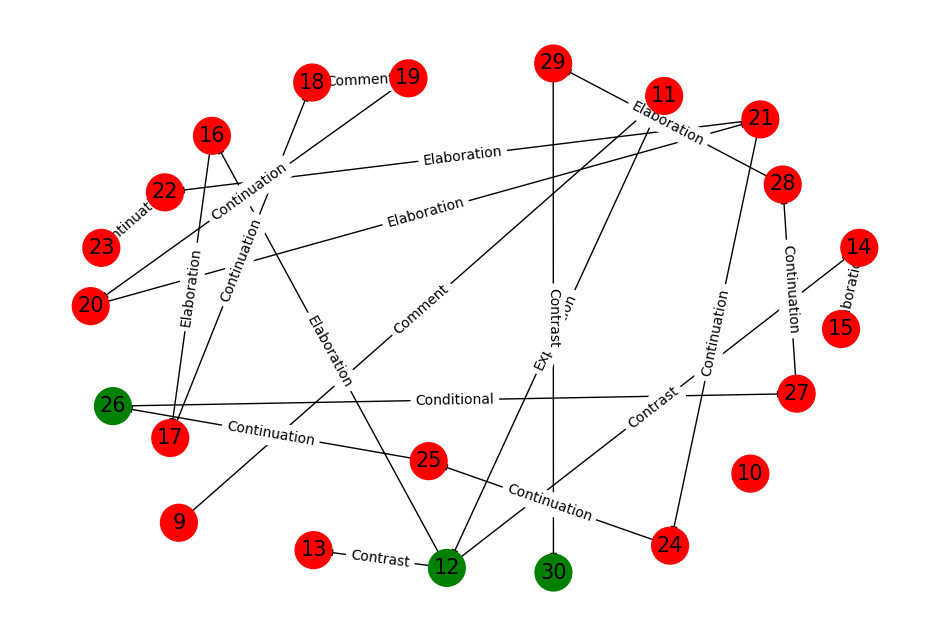

In [ ]:
# Create a directed graph
G = nx.DiGraph()
number_node = 20
start = 10

color_map = node_colors[:number_node+2]
# Add nodes
for vertex in vertices[start:start+number_node]:
  G.add_node(vertex)

# Add edges with labels
for key in list(couple_link.keys())[start:start+number_node]:
  G.add_edge(key[0], key[1], label=couple_link[key])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2)  # positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos,node_color=color_map, node_size=700)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=15)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis("off")  # Turn off axis
plt.show()


## Models

In [111]:
X_encode = bert.encode(filtered_sentences, show_progress_bar=True)

Batches:   0%|          | 0/2270 [00:00<?, ?it/s]

In [112]:
X_encode.shape

(72623, 384)

In [73]:
lengths = np.array([[len(sentence.split()) for sentence in cleaned_sentences]])

Addressing unbalanced dataset

In [113]:
X_train = np.array(X_encode)
y_train = np.array(y_training)
X_train.shape

(72623, 384)

In [114]:
relation_one_hot.shape

(72623, 17)

In [115]:
X_train = np.concatenate([X_train, relation_one_hot], axis=1)
#X_train = np.concatenate([X_train, lengths.T], axis=1)

In [117]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'y_train' contains your training labels
# And it's a binary or multiclass label encoded as integers
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict[1] = 2.3

### NN models

In [ ]:
from keras.regularizers import l1, l2
from tensorflow.keras.metrics import Recall

In [147]:
num_classes = 2

model = Sequential([
  layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu',),
  #layers.Dropout(0.5),
  #layers.Dense(16, activation='relu'),
  #layers.Dropout(0.5),
  #layers.Dense(16, activation='relu'),
  #layers.Dense(16, activation='relu'),
  #layers.Dense(16, activation='relu'),
  #layers.Dense(8, activation='relu'),
  #layers.Dropout(0.2),
  #layers.Dense(4, activation='tanh'),
  layers.Dense(2,activation='softmax' )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
#

In [ ]:
##SMOTE to adress umbalanced issues

In [118]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=40)

In [79]:
from imblearn.over_sampling import SMOTE
print("Before oversampling: ", dict(zip(*np.unique(y_train, return_counts=True))))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Summarize new class distribution
print("After oversampling: ", dict(zip(*np.unique(y_train_smote, return_counts=True))))

Before oversampling:  {0: 41478, 1: 9358}
After oversampling:  {0: 41478, 1: 41478}


In [123]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the random under sampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# X_resampled and y_resampled now contain a balanced dataset


In [148]:
epochs=5

history = model.fit(X_train, y_train, epochs=epochs) # class_weight=class_weights_dict

Epoch 1/5
1589/1589 [==============================] - 9s 3ms/step - loss: 0.3425 - accuracy: 0.8309
Epoch 2/5
1589/1589 [==============================] - 6s 4ms/step - loss: 0.3261 - accuracy: 0.8406
Epoch 3/5
1589/1589 [==============================] - 6s 4ms/step - loss: 0.3216 - accuracy: 0.8417
Epoch 4/5
1589/1589 [==============================] - 5s 3ms/step - loss: 0.3166 - accuracy: 0.8453
Epoch 5/5
1589/1589 [==============================] - 6s 4ms/step - loss: 0.3123 - accuracy: 0.8497


In [144]:
y_pred = np.argmax(model.predict(X_dev), axis =1)
#probs = model.predict(X_dev)


681/681 [==============================] - 2s 3ms/step


In [145]:
from sklearn.metrics import f1_score
f1_score(y_dev, y_pred)

0.5008670520231214

In [146]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_dev, y_pred)

array([[16600,  1253],
       [ 2201,  1733]])

In [84]:
unique, counts = np.unique(y_pred, return_counts=True)
counts

array([13715,  8072])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test prepocessing

In [ ]:
test_labels = {}
X_test = []
relation_list_test = []
for transcription_id in test_set:
    with open(path_to_test / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)
    with open(path_to_test / f"{transcription_id}.txt", "r") as file:
        transcription_relationship = file.readlines()
    count = 0
    for utterance in transcription:
        X_test.append(utterance["speaker"] + ": " + utterance["text"])
        if count == len(transcription)-1:
          relation = "end of transcription"
        else:
          relation = transcription_relationship[count].split()[1]
        relation_list_test.append(relation)
        count+=1
#sentence_lengths = np.array([[len(sentence.split()) for sentence in X_test]])


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Example data
relation_test_one_hot = np.array(relation_list_test).reshape(-1, 1)

relation_test_one_hot = encoder.transform(relation_test_one_hot)

relation_test_one_hot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(31026, 17)

In [ ]:
X_test = bert.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/970 [00:00<?, ?it/s]

In [ ]:
X_test.shape

(31026, 384)

In [ ]:
X_test = np.concatenate([X_test, relation_test_one_hot], axis=1)

In [ ]:
#X_test = np.concatenate([X_test, sentence_lengths.T], axis=1)
y_test = np.argmax(model.predict(X_test), axis =1)
y_test

970/970 [==============================] - 2s 2ms/step


array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/test_labels_naive_baseline.json', 'r') as file:
    data_dict = json.load(file)
print(data_dict)

{'ES2003a': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'ES2003b': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Submission routine

In [ ]:
id = []
for keys in test_set:
  for i in range(len(data_dict[keys])):
    id.append(keys+"_"+str(i))
id

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=['id', 'target_feature'])
df['id'] = id
df["target_feature"] = y_test
df.head()

,id,target_feature
0,ES2003a_0,0
1,ES2003a_1,1
2,ES2003a_2,0
3,ES2003a_3,0
4,ES2003a_4,0


In [ ]:
df.to_csv('test_labels_text_DL_5.csv', index=False, encoding='utf-8')

## GNN model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = X_train, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN(X_train[1], 2)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
accuracy = correct / data.test_mask.sum().item()

print(f'Accuracy: {accuracy:.4f}')
